# Fine-Tuning Transformer Models for Classification of Digital

Behavioural Data

Indira Sen (RWTH Aachen University)

## Learning Objectives

By the end of this tutorial, you will be able to fine-tune transformer
models like BERT for binary and multiclass document classification. We
show two options for using transformer models in Python

-   Simple Transformers
-   HuggingFace

As an example, we will fine-tune a specific transformer model
(DistilBERT) for automatic sexism detection.

## Target audience

This tutorial is aimed at social scientists with some knowledge in
Python and supervised machine learning.

## Setting up the computational environment

The following Python packages are required

``` python
!pip install pandas numpy torch sklearn
!pip install simpletransformers
!pip install transformers[torch]
```

This package is optional

``` python
!pip install accelerate -U
```

## Duration

It depends on the hardware. This notebook can be used with or without
GPU compute, but it’s much faster if you do have a GPU.

## Social Science Usecase(s)

This method has been used in Samory et al. (2021) for automatic sexism
detection.

## Import necessary Python libraries and modules

We will import necessary Python libraries and modules.

In [1]:
import pandas as pd
import numpy as np

# For deep learning
import torch

We then check if have a GPU available. This is important because some
parts of the code have to be modified later on based on this.

In [2]:
gpu_avail = torch.cuda.is_available()
gpu_avail

True

## Get the data

We first download the datasets we need for finetuning our models. This
is a **supervised** classification task, therefore, we will need labeled
data. We download the the ‘Call me sexist but’ (CMSB) dataset which you
can find here: <https://search.gesis.org/research_data/SDN-10.7802-2251>
This dataset is from our paper on detecting sexism in a theory-driven
manner (Samory et al., 2021).

Here, we can download the full data (‘sexism_data.csv’) and put it in
folder called ‘sexism_data’ in the same location as our jupyter
notebook. Here, we will use just a subset of the data for demonstration.

In [3]:
## sexism_data = pd.read_csv('sexism_data/sexism_data.csv')

sexism_data = pd.read_csv('sexism_data/sexism_sample.csv')

sexism_data.head()

In [4]:
sexism_data = sexism_data.dropna(subset = 'sexist')

## Finetuning a classifier: the general procedure

### With `simpletransformers`

We first use the [`simpletransformers`](https://simpletransformers.ai/)
package which is more beginner-friendly. The basic steps for finetuning
a classifier using simpletrasnformers are:

-   Initialize a model based on a specific architechture (BERT,
    DistilBERT, etc)
-   Train the model with train_model()
-   Evaluate the model with eval_model()
-   Make predictions on (unlabelled) data with predict()

In [5]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging

In [6]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

We need to preprocess the data first before we start the finetuning
process. In this step, we split the dataset into **train** and **test**
sets to have a fully held-out test set that can be used to evaluate our
classifier.

We can also create a **validation** that is used during the fine tuning
process for hyperparameter tuning, but that is not mandatory.

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(sexism_data, stratify=sexism_data['sexist'], test_size=0.2)

We now convert the dataframes into a format that can be read by
simpletransformers. This is a dataframe with the columns ‘text’ and
‘labels’. The ‘labels’ column should be numerical, so we use **one-hot
encoding** to transform our boolean sexist labels to numerical ones.

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_df['sexist'])
train_df['labels'] = le.transform(train_df['sexist'])
test_df['labels'] = le.transform(test_df['sexist'])

In [9]:
# to see which number was mapped to which class:
list(le.inverse_transform([0,1]))

[False, True]

So, 0 is non-sexist and 1 is sexist. We now have the appropriate data
structure.

The next step is setting the training parameters and loading the
classification model, in this case, DistilBERT (Sanh et al., 2019), a
lightweight model that can be trained relatively quickly compared to
other transformer variants like BERT and RoBERTa.

For training parameters, we have many to choose from such as the
learning rate, whether we want to stop early or not, where we should
save the model, and more. You can find all of them
[here](https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model).

As a minimal setup, we will just set the number of **epochs**, i.e., the
number of passes the model does over the full training set. For recent
transformer models, epochs are usually set to 2 or 3, after which
overfitting may happen.

**use_cuda** is a parameter that signals whether the GPU should be used
or not. It will be set based on our check earlier.

In [10]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=3, overwrite_output_dir=True)

# Create a ClassificationModel
model = ClassificationModel(
    "distilbert", "distilbert-base-uncased", args=model_args, use_cuda=gpu_avail,
)

# we set some additional parameters when using a GPU
if gpu_avail:
    model_args.use_multiprocessing=False
    model_args.use_multiprocessing_for_evaluation=False

/home/chainsawriot/miniconda/envs/sexism/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

We are now finally ready to begin training! This might take a while,
especially when we’re not using a GPU.

In [11]:
# Train the model
model.train_model(train_df)

(60, 0.4315023422241211)

After training our model, we can use it to make predictions for
unlabeled datapoints to classify whether they are sexist or not.

In [12]:
sexist_tweet = "A woman will never be truly fulfilled in life if she doesn’t have a committed long-term relationship with a man"
predictions, raw_outputs = model.predict([sexist_tweet])
le.inverse_transform(predictions)

array([ True])

In [13]:
nonsexist_tweet = "International Women's Day (IWD) is a holiday celebrated annually on March 8 as a focal point in the women's rights movement."
predictions, raw_outputs = model.predict([nonsexist_tweet])
le.inverse_transform(predictions)

array([ True])

We can also use the held-out test set to quantitatively evaluate our
model.

In [14]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_df)
result

{'mcc': 0.7,
 'accuracy': 0.85,
 'f1_score': 0.85,
 'tp': 17,
 'tn': 17,
 'fp': 3,
 'fn': 3,
 'auroc': 0.9475,
 'auprc': 0.9507699589693299,
 'eval_loss': 0.3428993225097656}

In [15]:
# you can also use sklearn's neat classification report to get more metrics
from sklearn.metrics import classification_report

preds, _ = model.predict(list(test_df['text'].values))
# preds = le.inverse_transform(preds)

print(classification_report(test_df['labels'], preds))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        20
           1       0.85      0.85      0.85        20

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40


## Conclusion

That’s a wrap on fine-tuning your own transformer models for text
classification. You can replace the sexism dataset with any other
labeled dataset of your choice for a particular task to train a
classifier for that task. More further reading and examples, see:

-   <https://www.aiforhumanists.com/tutorials/>
-   <https://huggingface.co/docs/transformers/en/training>

### With HuggingFace `transformers`

We now repeat the same process with the HuggingFace [`transformers`
Python library](https://huggingface.co/transformers/installation.html).
Additionally, we also use the [accelerate
library](https://huggingface.co/docs/accelerate/index), which helps make
our code more efficient. We will again use DistilBERT.

In [16]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

We will set some of the configurations, including whether to use a GPU
or not.

In [17]:
model_name = 'distilbert-base-uncased'
if gpu_avail:
    device_name = 'cuda'
else:
    device_name = 'cpu'

# This is the maximum number of tokens in any document; the rest will be truncated.
max_length = 512

# This is the name of the directory where we'll save our model. You can name it whatever you want.
cached_model_directory_name = 'output_hf'

We will reuse the train-test splits we created for simpletransformers,
but change the data structure slightly.

In [18]:
train_texts = train_df['text'].values
train_labels = train_df['labels'].values

test_texts = test_df['text'].values
test_labels = test_df['labels'].values

Compared to simpletransformers, we get a closer look at what happens
‘under the hood’ with huggingface. We will see the transformation of the
text better — each tweet will be truncated if they’re more than 512
tokens or padded if they’re fewer than 512 tokens.

The tokens will be separated into “word pieces” using the transformers
tokenizers (‘DistilBertTokenizerFast’ in this case to match the
DistiBERT model). And some special tokens will also be added such as
**CLS** (start token of every tweet) and **SEP** (separator between each
sentence {not tweet}):

In [19]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

We now encode our texts using the tokenizer.

In [20]:
from datasets import Dataset

train_df = Dataset.from_pandas(train_df)
test_df = Dataset.from_pandas(test_df)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_train_df = train_df.map(tokenize_function, batched=True)
tokenized_test_df = test_df.map(tokenize_function, batched=True)

We now load the DistilBERT model and specify that it should use the GPU.

In [21]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to()

As we did with simpletransformers, we now set the training parameters,
i.e., the number of epochs.

In [22]:
import accelerate

In [23]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    output_dir='./results',          # output directory
    report_to='none'
)

#### Fine-tune the DistilBERT model

First, we define a custom evaluation function that returns the accuracy.
You could modify this function to return precision, recall, F1, and/or
other metrics.

In [24]:
from sklearn.metrics import accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
  }

Then we create a HuggingFace `Trainer` object using the
`TrainingArguments` object that we created above. We also send our
`compute_metrics` function to the `Trainer` object, along with our test
and train datasets.

In [25]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_train_df,         # training dataset
    compute_metrics=compute_metrics      # our custom evaluation function
)

Time to finally fine-tune!

In [26]:
trainer.train()

#### Save fine-tuned model

The following cell will save the model and its configuration files to a
directory in Colab. To preserve this model for future use, you should
download the model to your computer.

In [27]:
trainer.save_model(cached_model_directory_name)

(Optional) If you’ve already fine-tuned and saved the model, you can
reload it using the following line. You don’t have to run fine-tuning
every time you want to evaluate.

In [28]:
# trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)

We can now evaluate the model by predicting the labels for the test set.

In [29]:
predicted_results = trainer.predict(tokenized_test_df)

In [30]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels[0:5]

In [31]:
print(classification_report(tokenized_test_df['labels'],
                            predicted_labels))

You can now use this classifier on other types of data to label it for
potentially sexist content.

## Multi-class classification

In the previous parts, we finetuned a binary classifier for
differentiating sexist vs. non-sexist content. However, the CMSB dataset
has fine-grained labels for sexism based on **content** and
**phrasing**.

So we now use a multi-class classifier using simpletransformers, with a
few tweaks to our earlier code.

But first, we have to aggregate the annotations from all crowdworkers to
obtain the content and phrasing labels. For simplicity, we will use the
majority label (breaking ties randomly).

In [32]:
sexism_data_annotations = pd.read_csv('sexism_data/all_data_annotations.csv', sep = '\t')
sexism_data_annotations.head()

In [33]:
tweets = sexism_data_annotations['_id'].unique()

In [34]:
from collections import Counter

content_labels = []
phrasing_labels = []

for tweet in tweets:
    data_subset = sexism_data_annotations[sexism_data_annotations['_id'] == tweet]
    content_labels.append(Counter(data_subset['content'].values).most_common()[0][0]) # get the majority label for content
    phrasing_labels.append(Counter(data_subset['phrasing']).most_common()[0][0]) # get the majority label for phrasing

In [35]:
finegrained_sexism_data = pd.DataFrame([tweets, content_labels, phrasing_labels]).T
finegrained_sexism_data.columns = ['_id', 'content_label', 'phrasing_label']
finegrained_sexism_data

In [36]:
finegrained_sexism_data.groupby('content_label').size()

In [37]:
finegrained_sexism_data.groupby('phrasing_label').size()

The six content and three phrasing categories are:

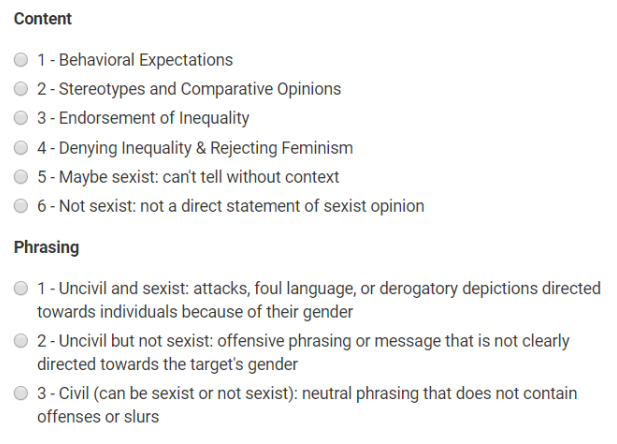

Let’s join this data with the tweets data from ‘all_data.csv’

In [38]:
finegrained_sexism_data = pd.merge(finegrained_sexism_data, sexism_data[['_id', 'text', 'sexist']])

In [39]:
finegrained_sexism_data.groupby(['content_label']).size()

Since our dataset is somewhat imbalanced with low representation for
some categories, we can restrict it to only those classes that have at
least 300 instances, i.e., 1, 2, and 6.

In [40]:
finegrained_sexism_data = finegrained_sexism_data[finegrained_sexism_data['content_label'].isin([1, 2, 6])]

# we also change the label range for simpletransformers, making them range from 0 to 2.
label_map = {1 : 0,
             2 : 1,
             6 : 2}
finegrained_sexism_data['content_label'] = [label_map[i] for i in finegrained_sexism_data['content_label']]
finegrained_sexism_data.groupby(['content_label']).size()

Let’s train a classifier for identifying sexist content or phrasing

In [41]:
category = 'content_label'

In [42]:
multi_train_df, multi_test_df = train_test_split(finegrained_sexism_data,
                                                 stratify=finegrained_sexism_data[category],
                                                 test_size=0.2)

You have the add the number of labels to the model initialization.

In [43]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=5,
                                output_dir='output_st',
                                overwrite_output_dir=True)

# Create a ClassificationModel
model = ClassificationModel(
    "distilbert", "distilbert-base-uncased", num_labels=len(finegrained_sexism_data[category].unique()),
    use_cuda=gpu_avail,
    args=model_args
)


# we set some additional parameters when using a GPU
if gpu_avail:
    model_args.use_multiprocessing=False
    model_args.use_multiprocessing_for_evaluation=False

In [44]:
# multi_train_df['content_label'] = [i-1 for i in multi_train_df['content_label']]
# multi_test_df['content_label'] = [i-1 for i in multi_test_df['content_label']]

In [45]:
multi_train_df = multi_train_df[['text', category]]
multi_test_df = multi_test_df[['text', category]]

In [46]:
# Train the model.
model.train_model(multi_train_df)

In [47]:
predictions, raw_outputs = model.predict([sexist_tweet])
predictions

In [48]:
preds, _ = model.predict(list(multi_test_df['text'].values))

In [49]:
print(classification_report(multi_test_df[category], preds))

We can see that the model performs worse than binary sexism
classification, but still better than a random chance model which would
have add an accuracy of 0.3 as we have three classes.

Samory, M., Sen, I., Kohne, J., Flöck, F., & Wagner, C. (2021). “Call me
sexist, but...”: Revisiting sexism detection using psychological scales
and adversarial samples. *<span class="nocase">Proceedings of the
international AAAI conference on web and social media</span>*, *15*,
573–584. <https://doi.org/10.1609/icwsm.v15i1.18085>

Sanh, V., Debut, L., Chaumond, J., & Wolf, T. (2019). DistilBERT, a
distilled version of BERT: Smaller, faster, cheaper and lighter. *arXiv
Preprint arXiv:1910.01108*. <https://arxiv.org/abs/1910.01108>